In [562]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

savepath = "results/P1Q3/"

In [563]:
dt = 0.002            
T  = 50.0              
N  = int(T / dt)      
rng = np.random.default_rng(np.random.randint(0, 100))

tau   = 0.010         
omega = 0.3 * 1000.0   
kernel_Tmax = 0.05

theta  = 5.0          
Delta  = 1.0           
target_rate = 20.0    

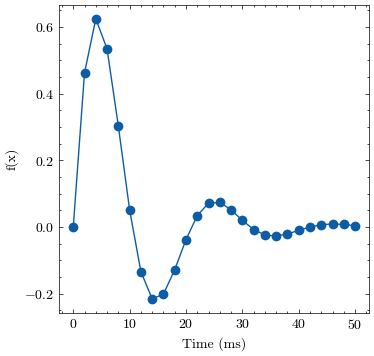

In [564]:
# stimulus 
t = np.arange(N) * dt
s = rng.normal(0.0, 1.0, size=N)  
# linear temporal filter
t_k = np.arange(0.0, kernel_Tmax + dt, dt)
f = np.exp(-t_k / tau) * np.sin(omega * t_k)

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(t_k * 1000, f, "-o")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("f(x)")
fig.savefig(savepath + "f.png", dpi=1000)

If we define: 
\begin{equation}
    \sigma(z) = \dfrac{1}{1 + e^{-z}}
\end{equation}
then: 
\begin{equation}
    r(t) = r_{\max}\sigma\left(\dfrac{u_f(t)-\theta}{\Delta}\right). 
\end{equation}
The mean firing rate scaled linearly with $r_{\max}$: 
\begin{equation}
    \bar{r} = \dfrac{1}{N}\sum_t r(t) = r_{\max} \underbrace{\dfrac{1}{N} \sum_t \sigma\left(\dfrac{u_f(t)-\theta}{\Delta}\right)}_{\bar{\sigma}}
\end{equation}
Thus: 
\begin{equation}
    r_{\max} = \dfrac{\text{target mean rate}}{\bar{\sigma}}. 
\end{equation}

In [565]:
u_full = np.convolve(s, f, mode="full")
u = u_full[:N]

def logistic(u, theta, Delta):
    return 1.0 / (1.0 + np.exp((theta - u) / Delta))

base_shape = logistic(u, theta, Delta)
mean_shape = base_shape.mean()

r_max_start = 1.0
r_max = r_max_start / mean_shape if mean_shape > 0 else target_rate 
r1 = r_max * base_shape 
spikes1 = rng.poisson(r1 * dt)  
print(spikes1)      
obs_rate1 = spikes1.sum() / (len(u) * dt) 
print(f"Observed mean with rmax=1: {obs_rate1:.2f} Hz")

rmax_star = target_rate / base_shape.mean()
r = rmax_star * base_shape   
spikes = rng.poisson(r * dt)
obs_rate = spikes.sum() / (len(u) * dt)
print(f"Tuned rmax = {rmax_star:.2f}; achieved mean ≈ {obs_rate:.2f} Hz")

[0 0 0 ... 0 0 0]
Observed mean with rmax=1: 1.00 Hz
Tuned rmax = 1747.91; achieved mean ≈ 21.06 Hz


In [566]:
N = len(s)
L = len(f)
assert L < N

num_spikes_total = int(spikes.sum())

sta = np.zeros(L, dtype=float)
den = spikes.sum()
print(spikes.shape)
print(den)
for k in range(L):
    sta[k] = np.dot(spikes[k:], s[:N-k]) / den
    
alpha = np.dot(f, sta) / np.dot(sta, sta)
sta_scaled = alpha * sta

def corr(a, b):
    a = (a - a.mean()) / (a.std() + 1e-12)
    b = (b - b.mean()) / (b.std() + 1e-12)
    return float(np.clip(np.dot(a, b) / len(a), -1, 1))

corr_unscaled = corr(f, sta)
corr_scaled = corr(f, sta_scaled)
print(corr_unscaled, corr_scaled)

(25000,)
1053
0.992003625654178 0.9920036256542133


In [567]:
sta_cum = np.zeros((L,), dtype=float)
corr_vs_spikes = []
count_spikes = 0
for n in range(N):
    kmax = min(L, n+1)
    if spikes[n] > 0:
        seg = s[n - (kmax-1): n+1][::-1] 
        padded = np.zeros(L)
        padded[:kmax] = seg
        sta_cum += spikes[n] * padded
        count_spikes += int(spikes[n])
        corr_vs_spikes.append(
            (count_spikes, corr(f, (sta_cum / count_spikes)))
        )

In [568]:
good_bpt = 0 
for npsk, val in corr_vs_spikes:
    if val > 0.9: 
        good_bpt = npsk
        break

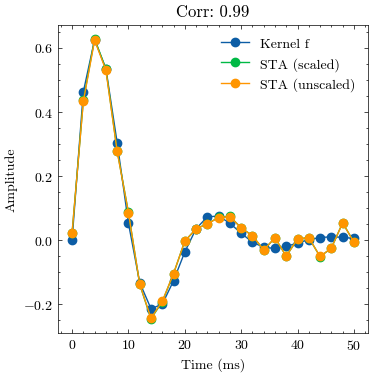

In [569]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(t_k * 1000, f, "-o", label="Kernel f")
ax.plot(t_k * 1000, sta_scaled, "-o", label="STA (scaled)")
ax.plot(t_k * 1000, sta, "-o", label="STA (unscaled)")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Amplitude")
ax.set_title(f"Corr: {corr_scaled:.2f}")
ax.legend()
fig.savefig(savepath + "f_sta_scaled.png", dpi=1000)

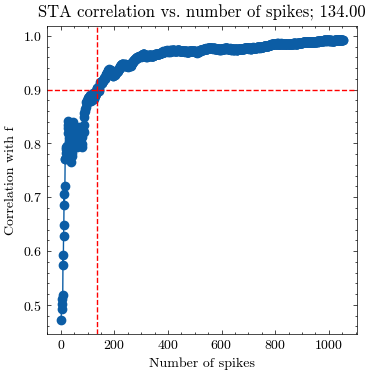

In [570]:
nspk_arr = np.array([x[0] for x in corr_vs_spikes])
corr_arr = np.array([x[1] for x in corr_vs_spikes])
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(nspk_arr, corr_arr, "-o")
ax.set_xlabel("Number of spikes")
ax.set_ylabel("Correlation with f")
# ax.set_xscale("log")
ax.set_title(f"STA correlation vs. number of spikes; {good_bpt:.2f}")
ax.axvline(good_bpt, color='red', linestyle='--')
ax.axhline(0.9, color='red', linestyle='--')
# ax.legend()
fig.savefig(savepath + "corr_vs_nspikes.png", dpi=1000)

In [571]:
theta, Delta = 15.0, 2.0

def quad_sigmoid(u, theta=theta, Delta=Delta):
    return 1.0 / (1.0 + np.exp((theta - u*u) / Delta))

base_shape = quad_sigmoid(u, theta, Delta)
mean_shape = base_shape.mean()
target_rate = 20.0 
rmax = target_rate / base_shape.mean()
r = rmax * base_shape

lam = r * dt
spikes = rng.poisson(lam)
obs_rate = spikes.sum() / (N * dt)
print(f"Total spikes: {int(spikes.sum())}, achieved mean rate ≈ {obs_rate:.2f} Hz (target 20 Hz)")

Total spikes: 948, achieved mean rate ≈ 18.96 Hz (target 20 Hz)


In [572]:
sta = np.zeros(L, dtype=float)
den = spikes.sum()
for k in range(L):
    sta[k] = np.dot(spikes[k:], s[:N-k]) / den
print(sta)

[-8.48059178e-02  6.73590860e-02  1.26127639e-01  7.27079352e-02
  6.83613369e-02  7.22079582e-05 -1.47095770e-03 -2.03744725e-02
 -3.72120918e-03  3.80902701e-02  5.33784194e-02  8.00591513e-02
  2.94996780e-02 -5.23574003e-02 -4.50797581e-03  5.74363169e-02
  9.26122461e-03  6.18490544e-02  1.26812323e-02 -5.02668298e-02
 -1.73608488e-02  7.21771968e-03  1.85035035e-02  2.13091622e-02
 -3.81038119e-02 -7.18952484e-02]


Let stimulus segment $s \sim \mathcal{N}(0,I_L)$ with linear drive $u=f^{\top}s$, $f\in \mathbb{R}^L$. Spiking in a small bin of width $dt$ is approximately Poisson with rate: 
\begin{equation}
    r(u) = \dfrac{r_{\max}}{1+\exp{((\theta-u^2)/\Delta)}}
\end{equation}
Thus: 
\begin{equation}
    \text{Pr}(\text{spike in }dt|s) \approx r(f^{\top}s)dt. 
\end{equation}
Because $s$ is Gaussian and $u=f^{\top}s$ is a linear projection, the joint distribution of $(u,s)$ is Gaussian, therefore the conditional expectation is: 

\begin{equation}
    \mathbb{E}(s|u) = \dfrac{f}{||f||^2}u. 
\end{equation}

Also: 

\begin{equation}
    p(s|\text{spike}) \propto r(f^{\top}s)p(s). 
\end{equation}

\begin{equation}
    \text{STA} = \mathbb{E}[s|\text{spike}] = \dfrac{\mathbb{E}[sr(u)]}{\mathbb{E}[r(u)]}. 
\end{equation}

\begin{equation}
    \mathbb{E}[sr(u)] = \mathbb{E}[\mathbb{E}[s|u]r(u)] = \mathbb{E}\left[\dfrac{f}{||f||^2}ur(u)\right] = \dfrac{f}{||f||^2}\mathbb{E}[ur(u)]. 
\end{equation}

Thus: 
\begin{equation}
    \text{STA} = \dfrac{f}{||f||^2}\dfrac{\mathbb{E}[ur(u)]}{\mathbb{E}[r(u)]}. 
\end{equation}

If $r(u)$ is an even function, then the $\mathbb{E}[ur(u)]$ will 0 since it is an odd function. Therefore, up to sampling noise it contains no information about $f$. 

In [573]:
c_sta = corr(f, sta)
print(f"Correlation between f and STA: {c_sta:.2f}")

Correlation between f and STA: 0.57


In [574]:
from numpy.lib.stride_tricks import sliding_window_view

X = sliding_window_view(s, L)[:, ::-1] 
print(X.shape)
spk = spikes[L-1:] 
M, L = X.shape
S = spk.sum()

(24975, 26)


$X \in \mathbb{R}^{M \times L}$, $L$ window length, $\text{spk} \in \mathbb{R}^m$: spike count per row. 

\begin{equation}
    S = \sum_{m=1}^M \text{spk}_m
\end{equation}

Calculate prior, having $\mu_{\text{prior}}$ here to make the that the stimulus is properly aligned with zero mean in the calculation: 
\begin{equation}
\begin{aligned}
    \mu_{\text{prior}} = \dfrac{1}{M}\sum_m X_m, C_{\text{prior}} = \dfrac{1}{M}\sum_m (X_m - \mu_{\text{prior}})(X_m - \mu_{\text{prior}})^{\top}. 
\end{aligned}
\end{equation}
Calculation of STA and STC: 
\begin{equation}
    \mu_{\text{spike}} = \dfrac{1}{S}\sum_m \text{spk}_m X_m, C_{\text{spike}} = \dfrac{1}{S-1}\sum_m \text{spk}_m (X_m - \mu_{\text{spike}})(X_m - \mu_{\text{spike}})^{\top}. 
\end{equation}

In [575]:
mu_prior = X.mean(axis=0)
X0 = X - mu_prior
C_prior = (X0.T @ X0) / (M - 1)

mu_spike = (spk @ X) / S 
# print(mu_spike)
# print(sta)
assert np.allclose(mu_spike, sta, atol=1e-2)

M2_spike = (X.T @ (X * spk[:, None])) / S 
C_spike_population = M2_spike - np.outer(mu_spike, mu_spike)  
C_spike = (S / (S - 1)) * C_spike_population   

DeltaC = C_spike - C_prior

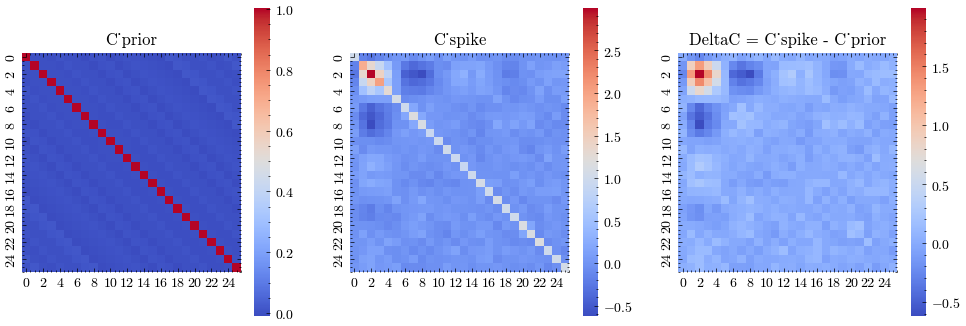

In [576]:
import seaborn as sns 
fig, ax = plt.subplots(1,3,figsize=(4*3,4))
sns.heatmap(C_prior, ax=ax[0], cmap="coolwarm", cbar=True, square=True)
sns.heatmap(C_spike, ax=ax[1], cmap="coolwarm", cbar=True, square=True)
sns.heatmap(DeltaC, ax=ax[2], cmap="coolwarm", cbar=True, square=True)
ax[0].set_title("C_prior")
ax[1].set_title("C_spike")
ax[2].set_title("DeltaC = C_spike - C_prior")
fig.savefig(savepath + "C_matrices.png", dpi=1000)

Top STC eigenvalue = 4.8444; corr(f, top eigenvector) = 0.986


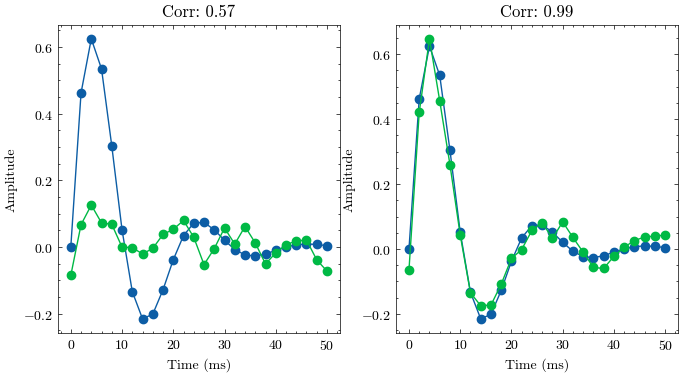

In [577]:
evals, evecs = np.linalg.eigh((DeltaC + DeltaC.T) / 2.0)
idx = np.argsort(np.abs(evals))[::-1]
evals = evals[idx]
evecs = evecs[:, idx]

v = evecs[:, 0]
if np.dot(v, f) < 0:
    v = -v

c_stc = corr(f, v)
print(f"Top STC eigenvalue = {evals[0]:.4f}; corr(f, top eigenvector) = {c_stc:.3f}")

fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(t_k * 1000, f, "-o", label="Kernel f")
ax[0].plot(t_k * 1000, sta, "-o", label="STA")
ax[0].set_title(f"Corr: {c_sta:.2f}")
ax[1].plot(t_k * 1000, f, "-o", label="Kernel f")
ax[1].plot(t_k * 1000, v, "-o", label="STA")
ax[1].set_title(f"Corr: {c_stc:.2f}")

for ax_ in ax:
    ax_.set_xlabel("Time (ms)")
    ax_.set_ylabel("Amplitude")
fig.savefig(savepath + "f_sta_stc.png", dpi=1000)

\begin{equation}
    \Delta C = \operatorname{Cov}(s|\text{spike}) - \operatorname{Cov}(s). 
\end{equation}
Let
\begin{equation}
    s = \dfrac{u}{||f||^2}f+\eta, \eta \perp f, \eta \sim \mathcal{N} \left( 0, \dfrac{ff^{\top}}{||f||^2} \right). 
\end{equation}
where $\eta$ independent of $u$. 
Then: 
\begin{equation}
    ss^{\top} = \dfrac{u^2}{||f||^4}ff^{\top} + \dfrac{u}{||f||^2}(f\eta^{\top}+\eta f^{\top}) + \eta \eta^{\top}. 
\end{equation}
The cross term vanishes $\mathbb{E}[u\eta|\text{spike}]=0$ by symmetry. The orthogonal covariance $\mathbb{E}[\eta \eta^{\top}|\text{spike}]$ equals its prior value because the weight $r(u)$ depends only on $u$, not on $\eta$. The only term that changes is along $ff^{\top}$. Also: 
\begin{equation}
    \mathbb{E}(ss^{\top}|\text{spike}) = \dfrac{\mathbb{E}[ss^{\top}r(u)]}{\mathbb{E}[r(u)]}. 
\end{equation}
Take spike-conditioned expectations, the only term that changes along is $ff^{\top}$. 
Thus: 
\begin{equation}
\mathbb{E}(ss^{\top}|\text{spike}) = \dfrac{\mathbb{E}[u^2r(u)]}{||f||^4\mathbb{E}[r(u)]}ff^{\top} + \mathbb{E}[\eta\eta^T]
\end{equation}
Thus, subtracting with $\mathbb{E}[ss^{\top}]$: 
\begin{equation}
    \Delta C = \underbrace{\left(\frac{\mathbb{E}[u^2 r(u)]}{\mathbb{E}[r(u)]}-\mathbb{E}[uu^{\top}]\right)}_{\alpha} \dfrac{1}{||f||^4}ff^{\top}. 
\end{equation}
Thus, $\Delta C$ with eigenvector $f$ (up to sign) and eigenvalue $\dfrac{\alpha}{||f||^2}$. Also, whitening will not rescue STA here, which will make $\text{STA} \propto C f\mathbb{E}[ru(r)]$. 

\begin{equation}
    r(u_f,u_g) = r_{\max}\sigma\left(\dfrac{u_f^2-\theta_f}{\Delta f}\right)\left(\dfrac{u_g^2-\theta_g}{\Delta g}\right)
\end{equation}

$\theta_f, \theta_g$ as thersholds, and $\Delta_f, \Delta_g$ as slope/softness. 

In [578]:
dt = 0.002                    
T  = 20.0                      
rng = np.random.default_rng(0)

tau_f   = 0.010              
omega_f = 0.3 * 1000.0         
tau_g   = 0.030                 
omega_g = 0.2 * 1000.0              

kernel_Tmax = 0.050            
t_k = np.arange(0.0, kernel_Tmax + dt, dt)            
f   = np.exp(-t_k / tau_f) * np.sin(omega_f * t_k)   
g   = -np.exp(-t_k / tau_g) * np.cos(omega_g * t_k)   
L   = len(t_k)

theta_f, theta_g = 15.0, 15.0
Delta_f, Delta_g = 2.0, 2.0
target_rate_hz   = 20.0

In [579]:
N = int(T / dt)
t = np.arange(N) * dt
s = rng.normal(0.0, 1.0, size=N)                    

u_f_full = np.convolve(s, f, mode="full")
u_g_full = np.convolve(s, g, mode="full")
u_f = u_f_full[:N]
u_g = u_g_full[:N]

In [580]:
base = 1.0 / (1.0 + np.exp((theta_f - u_f**2) / Delta_f))
base *= 1.0 / (1.0 + np.exp((theta_g - u_g**2) / Delta_g))

r_max = target_rate_hz / base.mean()    
print(r_max)             
r_hz  = r_max * base                                 
lam   = r_hz * dt                                 
spikes = rng.poisson(lam)                            
achieved_rate = spikes.sum() / (N * dt)
print(f"Achieved mean rate ≈ {achieved_rate:.2f} Hz (target {target_rate_hz} Hz)")

36840.16904357138
Achieved mean rate ≈ 18.65 Hz (target 20.0 Hz)


In [581]:
X = sliding_window_view(s, L)[:, ::-1]              
spk = spikes[L-1:].astype(float)
den = spk.sum()
STA = (spk @ X) / den

In [582]:
mu_prior = X.mean(axis=0, keepdims=True)
X0 = X - mu_prior
C_prior = (X0.T @ X0) / (X.shape[0] - 1)

mu_spike = (spk @ X) / den
X_spk0 = X - mu_spike
C_spike = ((X_spk0 * spk[:, None]).T @ X_spk0) / (den - 1)

DeltaC = C_spike - C_prior

evals, evecs = np.linalg.eigh((DeltaC + DeltaC.T) / 2.0)
order = np.argsort(np.abs(evals))[::-1]
evals = evals[order]
evecs = evecs[:, order]
v1, v2 = evecs[:, 0], evecs[:, 1]   

In [583]:
# uf_ax = np.linspace(np.percentile(u_f, 1), np.percentile(u_f, 99), 75)
# ug_ax = np.linspace(np.percentile(u_g, 1), np.percentile(u_g, 99), 75)
uf_ax = np.linspace(-10, 10, 1000)  
ug_ax = np.linspace(-10, 10, 1000)  

UF, UG = np.meshgrid(uf_ax, ug_ax, indexing="xy")
R_base = 1.0 / (1.0 + np.exp((theta_f - UF**2) / Delta_f))
R_base *= 1.0 / (1.0 + np.exp((theta_g - UG**2) / Delta_g))

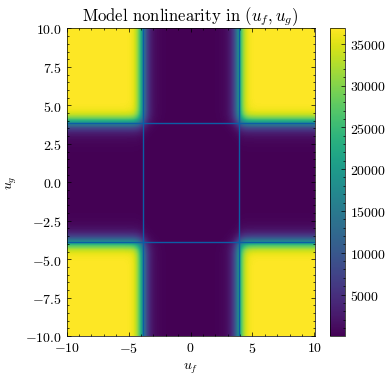

In [584]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
c = ax.pcolormesh(UF, UG, R_base * r_max, shading="auto")
u_half = np.sqrt(theta_f)
ax.axvline(+u_half)
ax.axvline(-u_half)
ax.axhline(+u_half)
ax.axhline(-u_half)
ax.set_xlabel(r"$u_f$")
ax.set_ylabel(r"$u_g$")
ax.set_title("Model nonlinearity in $(u_f,u_g)$")
fig.colorbar(c, ax=ax)
fig.savefig(savepath + "model_nonlinearity.png", dpi=1000)

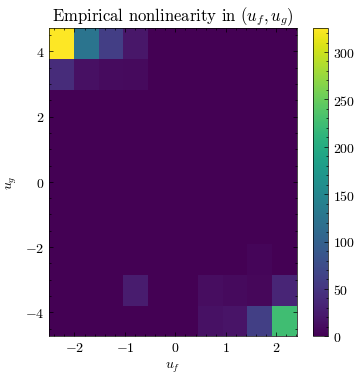

In [585]:
K = 10
uf_edges = np.linspace(np.percentile(u_f, 1), np.percentile(u_f, 99), K+1)
ug_edges = np.linspace(np.percentile(u_g, 1), np.percentile(u_g, 99), K+1)

uf_aligned = u_f[L-1:]
ug_aligned = u_g[L-1:]
spk_aligned = spk

H_counts, _, _ = np.histogram2d(uf_aligned, ug_aligned, bins=[uf_edges, ug_edges])
H_spikes, _, _ = np.histogram2d(uf_aligned, ug_aligned, bins=[uf_edges, ug_edges], weights=spk_aligned)

rate_hat = np.divide(H_spikes, H_counts, out=np.zeros_like(H_spikes), where=(H_counts > 0)) / dt

UFc = 0.5 * (uf_edges[:-1] + uf_edges[1:])
UGc = 0.5 * (ug_edges[:-1] + ug_edges[1:])
UFcM, UGcM = np.meshgrid(UFc, UGc, indexing="xy")

fig, ax = plt.subplots(1,1,figsize=(4,4))
c = ax.pcolormesh(UFcM, UGcM, rate_hat.T, shading="auto")
ax.set_xlabel(r"$u_f$")
ax.set_ylabel(r"$u_g$")
ax.set_title("Empirical nonlinearity in $(u_f,u_g)$")
fig.colorbar(c, ax=ax)
fig.savefig(savepath + "empirical_nonlinearity.png", dpi=1000)

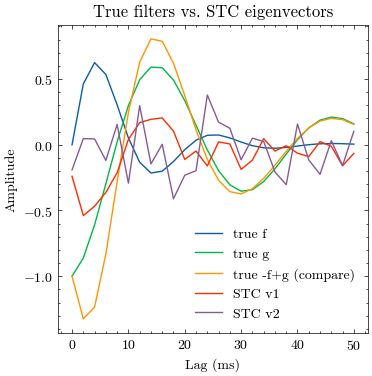

In [586]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(t_k * 1000.0, f, label="true f")
ax.plot(t_k * 1000.0, g, label="true g")
ax.plot(t_k * 1000.0, -f+g, label="true -f+g (compare)")
ax.plot(t_k * 1000.0, v1, label="STC v1")
ax.plot(t_k * 1000.0, v2, label="STC v2")
ax.set_xlabel("Lag (ms)")
ax.set_ylabel("Amplitude")
ax.set_title("True filters vs. STC eigenvectors")
ax.legend()
fig.savefig(savepath + "true_vs_stc_filters.png", dpi=1000)

We do not expect to see STC to be recovered, given the question's requirement. Again here $r$ depends on $u^2$ (even nonlinearities), the spike weighting is symmetric in $u$, so odd moments vanish. Plus, the stimulus is also zero-meaned. Therefore, we can safely ignore the mean correction term. Given Gaussian stimulus $s \sim \mathcal{N}(0,I)$: 

\begin{equation}
    u_f = f^{\top}s, u_g = g^{\top}s. 
\end{equation}

By Bayes rule and small-bin Poisson assumption:  
\begin{equation}
     p(s|\text{spike})\propto r(u_f,u_g)p(s)
\end{equation}

\begin{equation}
    \mathbb{E}[\Phi(s)|\text{spike}] = \dfrac{\mathbb{E}[\Phi(s) r(u_f,u_g)]}{\mathbb{E}[r(u_f,u_g)]}. 
\end{equation}

For notation simplicity, decompose $s$ into parts along $f$ and $g$, and the orthogonal complement:
\begin{equation}
s = af + bg + \eta, \eta \perp \{ f, g \}, \eta \sim \mathcal{N}(0,I-\Pi_{f,g}). 
\end{equation}
where $\Pi_{f,g}=FF^{+}$ the orthogonal projector onto $\text{span}\{ f,g \}$, and $a,b$ are zero-mean Gaussians (jointly Gaussian with $\eta$). 

$\eta$ is independent of $(u_f,u_g)$ (and $(a,b)$). $\mathbb{E}[\eta]=\mathbb{E}[u_f]=\mathbb{E}[u_g]=0$, $\mathbb{E}[u_f^2]=||f||^2, \mathbb{E}[u_g^2]=||g||^2$, and $\mathbb{E}[u_fu_g]=f^{\top}g$, $u_f = Aa+Cb$, $u_g = Ca+Bb$. 

If let $A=||f||^2, B=||g||^2, C=f^{\top}g, D=AB-C^2 > 0$, then: 
\begin{equation}
    a=\dfrac{Bu_f-Cu_g}{D}, b=\dfrac{Au_g-Cu_f}{D}. 
\end{equation}
If orthogonal but not unit-norm ($C=0$), $a=\dfrac{u_f}{A}, b=\dfrac{u_g}{B}$ which is very similar to the 1-kernel case. 

Explicitly: 

\begin{equation}
    ss^{\top}=a^2ff^{\top}+b^2gg^{\top}+ab(fg^{\top}+gf^{\top})+a(f\eta^{\top}+\eta f^{\top})+b(g\eta^{\top}+\eta g^{\top}) + \eta \eta^{\top}.
\end{equation}

Using Bayes: 
\begin{equation}
    \mathbb{E}[ss^{\top}|\text{spike}] = \dfrac{\mathbb{E}[ss^{\top}r(u_f,u_g)]}{\mathbb{E}[r(u_f,u_g)]}. 
\end{equation}

We can then analyze term by term. Importantly, the mixed $\eta$ terms vanish, and $\mathbb{E}[\eta \eta^{\top} r] = \mathbb{E}[r]\mathbb{E}[\eta \eta^{\top}]$ by independence. 

\begin{equation}
    \mathbb{E}[ss^{\top}|\text{spike}] = \beta_{ff}ff^{\top} + \beta_{gg}gg^{\top} + \beta_{fg}(fg^{\top} + gf^{\top}) + \mathbb{E}[\eta \eta^{\top}], 
\end{equation}
with: 
\begin{equation}
    \beta_{ff} = \dfrac{\mathbb{E}[a^2 r]}{\mathbb{E}[r]}, \beta_{gg} = \dfrac{\mathbb{E}[b^2 r]}{\mathbb{E}[r]}, \beta_{fg} = \dfrac{\mathbb{E}[abr]}{\mathbb{E}[r]}. 
\end{equation}
As before: 
\begin{equation}
    \Delta C = \alpha_{ff}ff^{\top} + \alpha_{gg}gg^{\top} + \alpha_{fg}(fg^{\top} + gf^{\top}) + \mathbb{E}[\eta \eta^{\top}], 
\end{equation}

\begin{equation}
    \alpha_{ff}=\beta_{ff}-\mathbb{E}[a^2], \alpha_{gg}=\beta_{gg}-\mathbb{E}[b^2], \alpha_{fg}=\beta_{fg}-\mathbb{E}[ab]. 
\end{equation}

This says that $\operatorname{range}(\Delta C) \subseteq \operatorname{span}\{ f,g \}$ and $\operatorname{rank}(\Delta C) \le 2$. We can write: 
\begin{equation}
    \Delta C = FAF^{\top}
\end{equation}
where $F=[f,g]$ and $A \in \mathbb{R}^{2\times 2}$. Typically $\alpha_{ff}, \alpha_{gg} > 0$. If $A$ has off-diagonal mass, then the eigenvectors are rotated mixtures of $f$ and $g$. 

If $f$ and $g$ are orthogonal, then $u_f$ and $u_g$ are independent and $\alpha_{fg}=0$. If $\alpha_{ff} \neq \alpha_{gg}$, then eigenvectors are exactly $f$ and $g$ (up to sign). Otherwise the top two eigenvalues are degenerated and any orthonormal pair inside $\{ f,g \}$ is an eigenbasis. Because $r_f(u)$ and $r_g(u)$ are increasing in $u^2$, spike weighting favors large $|u_f| and $|u_g|, hence $\alpha_{ff}, \alpha_{gg} > 0$. 